# DGRP phenotype analyses

This notebook explores potential nonlinearities between DGRP phenotypes. Phenotypic data were collected from a variety of publications and were selected to attempt to span the full range of phenotypic space. The compiled dataset is available via [S3](https://arcadia-public-genetic-mapping-datasets.s3.us-west-1.amazonaws.com/dgrp_phenotypes/). 
***

## Load and compile phenotypes

Load packages

In [24]:
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(gplots))
suppressPackageStartupMessages(library(missMDA))
suppressPackageStartupMessages(library(FactoMineR))
suppressPackageStartupMessages(library(RNOmni))
suppressPackageStartupMessages(library(umap))
suppressPackageStartupMessages(library(energy))
suppressPackageStartupMessages(library(mgcv))
suppressPackageStartupMessages(library(lmtest))
suppressPackageStartupMessages(library(scales))

Make temporary folder to download DGRP phenotype data into

In [9]:
system('mkdir dgrp_phenotypes')

Download DGRP phenotype data from S3

In [10]:
system('aws s3 cp s3://arcadia-public-genetic-mapping-datasets/dgrp_phenotypes/ dgrp_phenotypes/ --recursive')

Move to phenotype directory

In [11]:
setwd('dgrp_phenotypes/')

List files

In [12]:
files = list.files()

Loop through, load, and clean

In [13]:
dgrp = list()
for(i in 1:length(files)){
  setwd(files[i])
  x = list.files()
  x = x[grep('.csv', x)]
  if(length(x)>0){
    for(j in 1:length(x)){
      d = as.data.frame(read.csv(x[j], row.names = NULL))
      if(ncol(d)>2){
        lines = d[,1]
        n = colnames(d[,2:ncol(d)])
        d = split(t(d[,2:ncol(d)]), 2:ncol(d))
        for(k in 1:length(d)){
          dgrp[[paste(n[k], files[i], sep = '-')]] = as.data.frame(cbind(lines, d[[k]]))
        }
      }else{
        dgrp[[paste(colnames(d)[2], files[i], sep = '-')]] = d
      }
    }
  }
  setwd('../')
}

Extract all unique DGRP lines contained in the data sets

In [14]:
lines = unique(unlist(lapply(dgrp, function(x) x$line)))
lines = lines[!is.na(lines)]

Combine data

In [15]:
tmp = do.call(cbind, lapply(dgrp, function(x) x[match(lines, x$line),2:ncol(x)]))
rownames(tmp) = lines

Save

In [16]:
setwd('../')
write.csv(tmp, '02_output/all_dgrp_phenotypes.csv')

Remove temporary phenotype folder

In [ ]:
system('rm -r dgrp_phenotypes')

## Explore data using dimensionality reduction

Read in data

In [19]:
#Get and format names using readLines (rownames load weirdly otherwise)
n = readLines('02_output/all_dgrp_phenotypes.csv', n = 1)
n = lapply(strsplit(n, ','), function(x) substring(x, 2))
n = lapply(n, function(x) substr(x, 1, nchar(x)-1))
n = unlist(n)[-1]

#Load data matrix
dgrp = as.data.frame(data.matrix(read.csv('02_output/all_dgrp_phenotypes.csv',
                                          row.names = 1)))
colnames(dgrp) = n

Filter on missing data

In [20]:
dgrp = dgrp[apply(dgrp, 1, function(x) sum(is.na(x)))<50,]
dgrp = dgrp[,apply(dgrp, 2, function(x) sum(is.na(x)))<50]
dgrp = dgrp[,apply(dgrp, 2, function(x) length(unique(x)))>5]

Impute missing values using column means

In [21]:
for(i in 1:ncol(dgrp)){
  x = which(is.na(dgrp[,i]))
  dgrp[x,i] = mean(dgrp[,i], na.rm = TRUE)
}

Normalize using rank normalization

In [25]:
dgrp_s = as.data.frame(apply(dgrp, 2, function(x) RankNorm(x)))

Correlate data

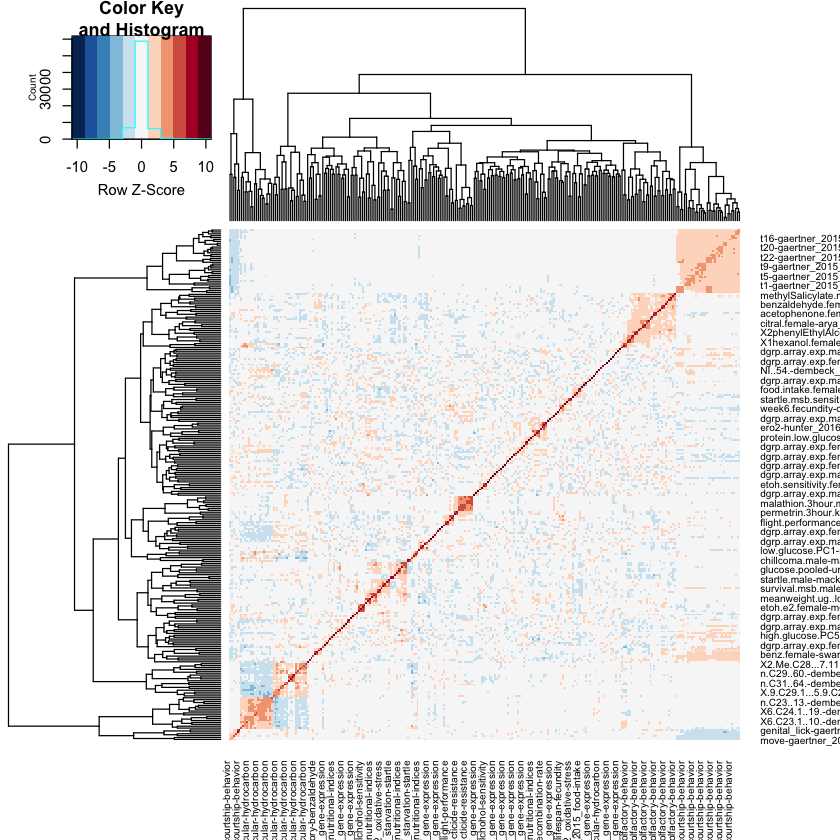

In [26]:
corr = cor(data.matrix(dgrp_s), use = 'complete.obs')
heatmap.2(corr,
          col=rev(brewer.pal(11,"RdBu")),
          scale="row", 
          trace="none")

PCA

In [27]:
pca = prcomp(t(dgrp_s), scale. = TRUE, center = FALSE)

Plot by study

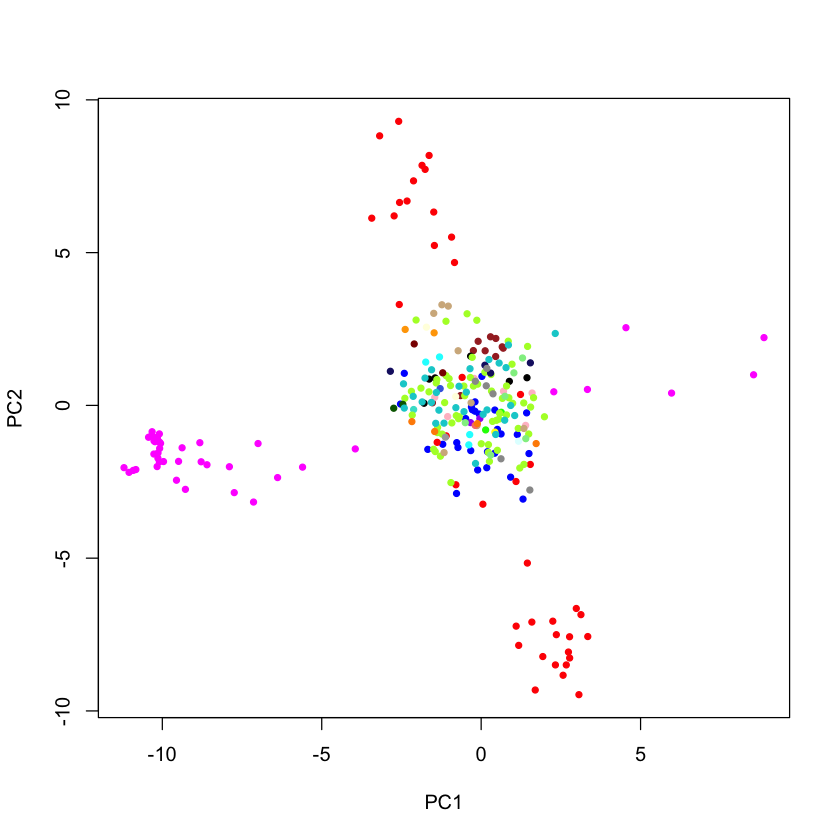

In [28]:
s = unlist(lapply(strsplit(colnames(dgrp), "-"), function(v){v[2]}))

qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
cols = WGCNA::standardColors(n = length(unique(s)))
names(cols) = unique(s)
cols = cols[match(s, names(cols))]

plot(pca$x[,1:2], pch = 20, col = cols)

UMAP

[2022-09-20 18:30:22]  starting umap

[2022-09-20 18:30:23]  creating graph of nearest neighbors

[2022-09-20 18:30:23]  creating initial embedding

[2022-09-20 18:30:23]  optimizing embedding

[2022-09-20 18:30:23]  done



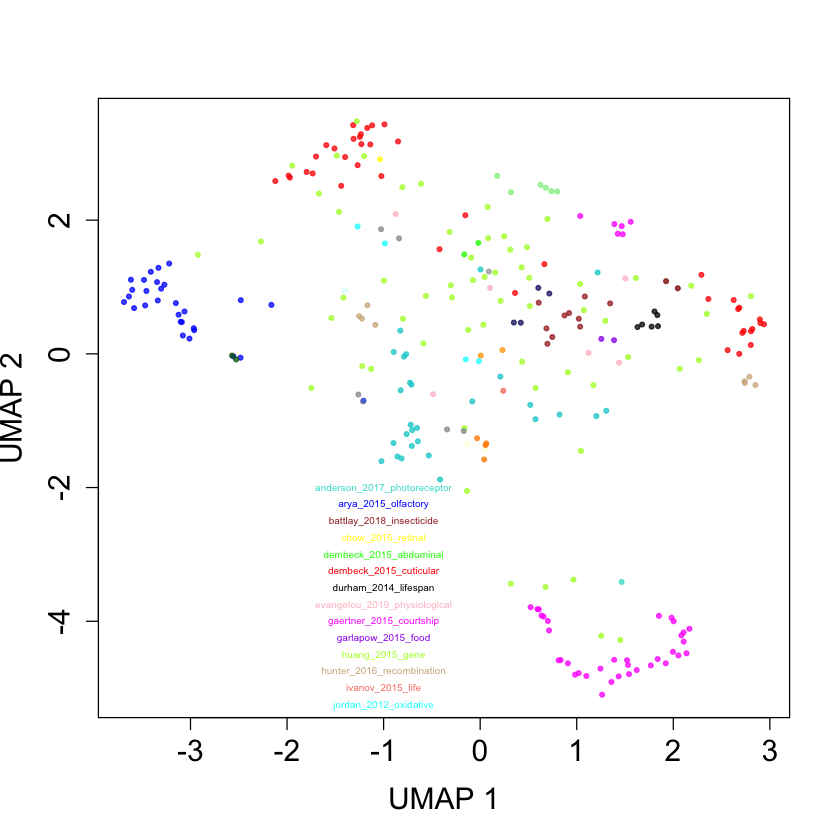

In [31]:
set.seed(666)
u = umap(t(dgrp_s))

plot(u$layout, 
     pch = 20, 
     cex = 0.8,
     col = alpha(cols, 0.75),
     xlab = 'UMAP 1',
     ylab = 'UMAP 2',
     cex.axis = 1.5,
     cex.lab = 1.5)

y = seq(-2, -8, -0.25)
for(i in 1:length(unique(s))){
  text(-1, y[i], unique(s)[i], cex = 0.5, col = unique(cols)[i])
}

## Testing linear vs. non-linear components via models

Calculate all possible comparisons

In [32]:
all = expand.grid(1:ncol(dgrp_s), 1:ncol(dgrp_s))

Convert data to numeric matrix

In [33]:
z = data.matrix(dgrp_s)

Calculate linear and non-linear models for all traits (note: takes a long time to run)

In [36]:
#Initiate progress bar
pb <- txtProgressBar(min = 0,      
                     max = nrow(all), 
                     style = 3,    
                     width = 50,
                     char = ".")

#Loop through and run
res = list()
for(i in 1:nrow(all)){
  
  #Update progress bar
  setTxtProgressBar(pb, i)
  
  mod1 = lm(z[,all[i,1]]~z[,all[i,2]])
  mod2 = gam(z[,all[i,1]]~s(z[,all[i,2]], k = length(unique(z[,all[i,2]]))-1))
  
  out = lrtest(mod1, mod2)
  a = AIC(mod1, mod2)
  
  l = list(out, a)
  names(l) = c('lrtest', 'AIC')
  
  res[[paste(colnames(dgrp_s)[all[i,1]],
             colnames(dgrp_s)[all[i,2]], 
             sep = '_')]] = l
}

  |..................................................| 100%

Save

In [39]:
saveRDS(res, '02_output/dgrp_linear_nonlinear_models.RDS')

Compare with AIC

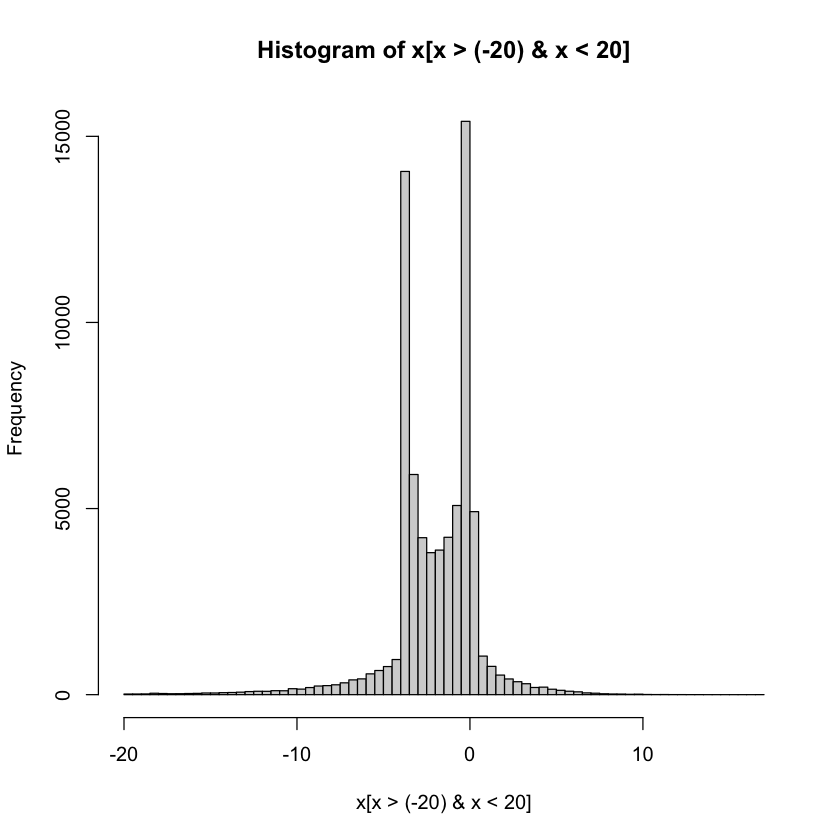

In [40]:
x = unlist(lapply(res, function(x) x$AIC[2,2]-x$AIC[1,2]))
hist(x[x>(-20)&x<20], breaks = 100)

Compare with likelihood

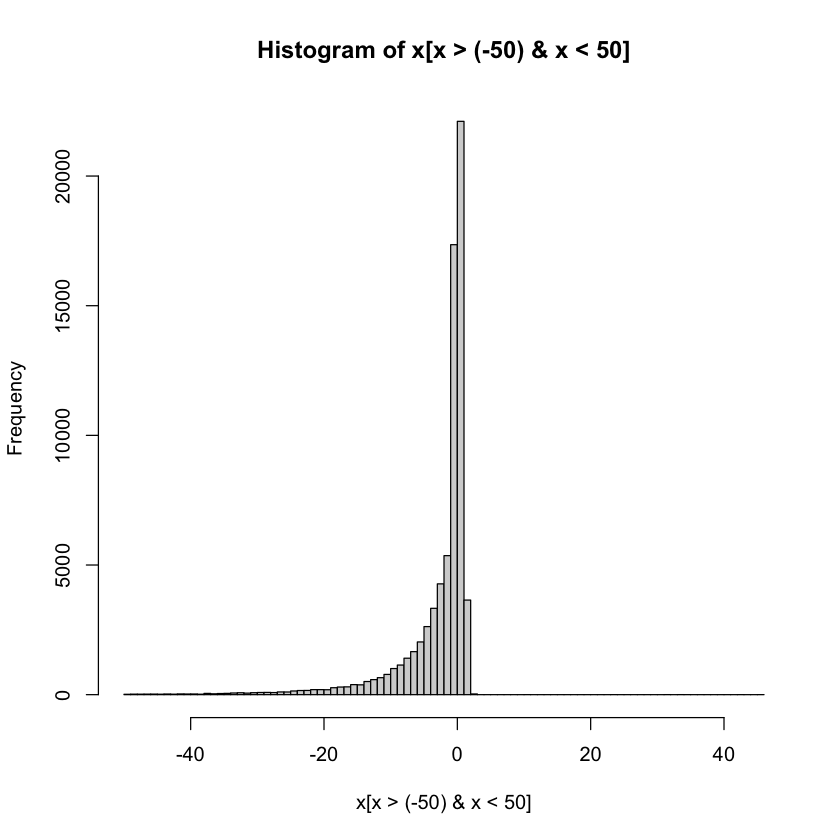

In [41]:
x = unlist(lapply(res, function(x) x$lrtest$LogLik[1]-x$lrtest$LogLik[2]))
hist(x[x>(-50)&x<50], breaks = 100)

Calculate breakdown of linear vs. nonlinear 

In [43]:
x = unlist(lapply(res, function(x) x$lrtest$LogLik[1]-x$lrtest$LogLik[2]))
linear = sum(x>0)/length(x)
nonlinear = sum(x<0)/length(x)
print(c(linear, nonlinear))

[1] 0.3572291 0.6427709


Barplot

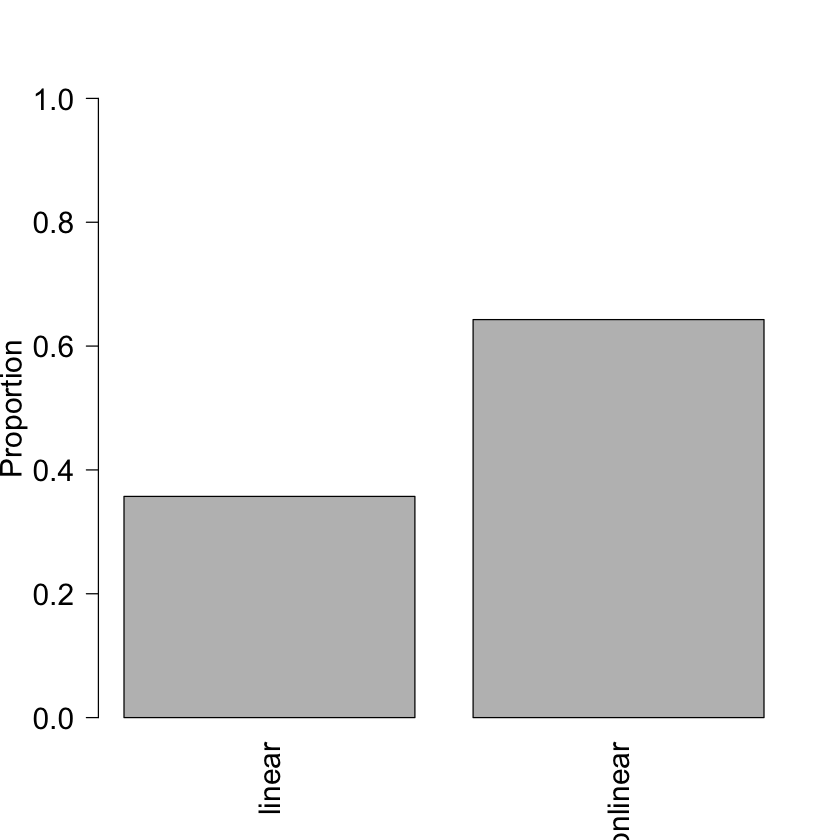

In [46]:
barplot(c(linear, nonlinear),
       ylab = 'Proportion',
       ylim = c(0,1),
       cex.axis = 1.5, cex.lab = 1.5, cex.names = 1.5,
       names = c('linear', 'nonlinear'),
       las = 2)